# Preliminary ML Model

In [135]:
import pandas as pd
import numpy as np
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from random import sample

play_injuries = pd.read_csv('play_injuries.csv')
play_injuries.head()

,PlayKey,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart
0,26624-1-1,1.0,1.0,Synthetic,63.0,1.0,0.0,Outdoor,Clear,Pass,QB,QB,NoInjury
1,26624-1-2,1.0,1.0,Synthetic,63.0,2.0,0.0,Outdoor,Clear,Pass,QB,QB,NoInjury
2,26624-1-3,1.0,1.0,Synthetic,63.0,3.0,0.0,Outdoor,Clear,Rush,QB,QB,NoInjury
3,26624-1-4,1.0,1.0,Synthetic,63.0,4.0,0.0,Outdoor,Clear,Rush,QB,QB,NoInjury
4,26624-1-5,1.0,1.0,Synthetic,63.0,5.0,0.0,Outdoor,Clear,Pass,QB,QB,NoInjury


<AxesSubplot:title={'center':'Player Day Density'}, ylabel='Density'>

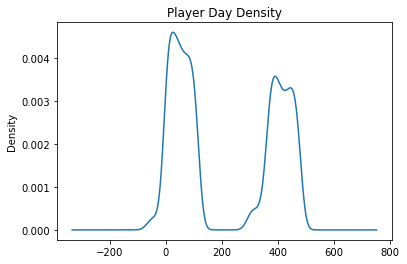

In [136]:
play_injuries.PlayerDay.plot.density(title="Player Day Density")

<AxesSubplot:title={'center':'Player Game Density Plot'}, ylabel='Density'>

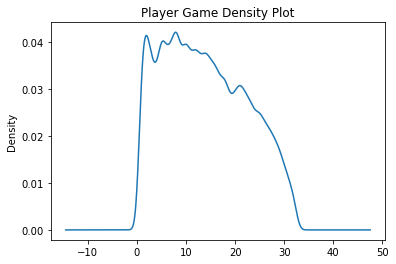

In [137]:
# PlayerGame Plot Density
play_injuries.PlayerGame.plot.density(title="Player Game Density Plot")

In [138]:
# play_injuries.FieldType.plot.density(title='Field Type Density')

<AxesSubplot:title={'center':'Player Game Play Density'}, ylabel='Density'>

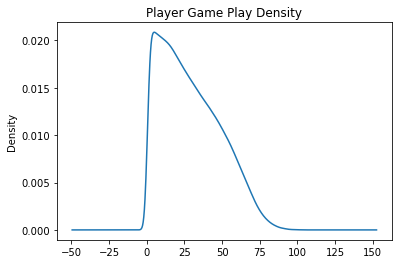

In [139]:
play_injuries.PlayerGamePlay.plot.density(title="Player Game Play Density")

<AxesSubplot:title={'center':'Injury Duration Density'}, ylabel='Density'>

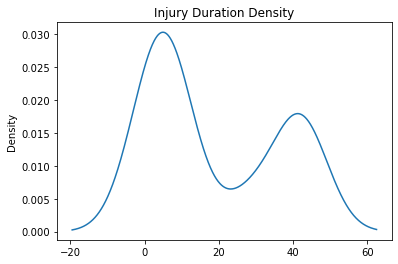

In [140]:
# Because there are so many more non-injuries than injured days, the density plot doesn't 
# show anything useful with the single spike at 0, so all non-injuries are removed
play_injuries.Injury_Duration[play_injuries.Injury_Duration != 0].plot.density(title="Injury Duration Density")

This is an interesting finding, in that most injuries were either short term, under 7 days or long term, extending to 42+ days

### Encode the object datasets

In [141]:
# Generate our categorical variable lists
play_injuries_categorical = play_injuries.dtypes[play_injuries.dtypes == 'object'].index.tolist()

The current dataset it too big to create dummies for, and would require 60 Gb of memory... So creating a random subset

In [142]:
play_injury_subset = play_injuries.sample(n=2000)

In [143]:
# Use get_dummies() to create variables for the text features
X = pd.get_dummies(play_injury_subset, columns=play_injuries_categorical)

### Use PCA to reduce dimentions to three principal components

In [144]:
X_pca = PCA(n_components=3).fit_transform(X)

In [145]:
# Create a DF with the three principal components
pcs_df = pd.DataFrame(data = X_pca, columns=['PC 1', 'PC 2', 'PC 3'])
pcs_df = pcs_df.set_index(play_injury_subset.index)
pcs_df.head()

,PC 1,PC 2,PC 3
158561,118.717713,26.482277,11.820825
87947,131.097082,-5.860295,1.619889
202770,-239.642262,-21.909724,24.944688
223735,-149.076849,-6.861481,0.290191
23302,-94.074782,14.578867,-15.175006


### Find Value for K with an Elbow Curve

In [146]:
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

elbow_data = {"k": k, 'inertia': inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x='k', y='inertia', title='Elbow Curve', xticks=k)

c:\Users\justi\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.



:Curve   [k]   (inertia)

### There is a distinct elbowing event at k=2


In [153]:
# Initialize the k-means model
model = KMeans(n_clusters=2, random_state = 5)

# Fit the model
model.fit(pcs_df)

# Predict the clusters
predictions = model.predict(pcs_df)
print(predictions)

[0 0 1 ... 1 0 1]


## Create a new DF with the PCA Analysis Results as Columns

In [154]:
# Concatenate the data with the Play_Injuries dataframe
clustered_play_injuries = pd.concat([play_injury_subset, pcs_df], axis=1)

In [155]:
# Add new column for the "Class", based on the predictions
clustered_play_injuries['Class'] = predictions


In [156]:
print(clustered_play_injuries.shape)
clustered_play_injuries.head()


(2000, 17)


,PlayKey,PlayerDay,PlayerGame,FieldType,Temperature,PlayerGamePlay,Injury_Duration,StadiumType,Weather,PlayType,RosterPosition,Position,BodyPart,PC 1,PC 2,PC 3,Class
158561,44203-14-57,97.0,14.0,Natural,53.0,57.0,0.0,Outdoor,Cloudy,Rush,WR,WR,NoInjury,118.717713,26.482277,11.820825,0
87947,41094-6-24,85.0,6.0,Natural,60.0,24.0,0.0,Outdoor,Clear,Pass,S,SS,NoInjury,131.097082,-5.860295,1.619889,0
202770,45077-27-10,455.0,27.0,Natural,33.0,10.0,0.0,Outdoor,Cloudy,Rush,OL,C,NoInjury,-239.642262,-21.909724,24.944688,1
223735,46119-16-23,365.0,16.0,Synthetic,59.0,23.0,0.0,Closed Dome,Cloudy,Punt Not Returned,LB,OLB,NoInjury,-149.076849,-6.861481,0.290191,1
23302,36555-18-43,310.0,18.0,Natural,77.0,43.0,0.0,Outdoor,Cloudy,Pass,DL,DT,NoInjury,-94.074782,14.578867,-15.175006,1


## Cluster Visualization 

In [161]:
fig = px.scatter_3d(
    clustered_play_injuries,
    x = "PC 1", 
    y = "PC 2", 
    z = "PC 3", 
    color='Class', 
    symbol='Class', 
    width=1200,
    height=1000, 
    title="3D Scatter Using PCA Parameters and K-Means Clustering On NFL Injury data", 
    hover_name = "FieldType", 
    hover_data=[clustered_play_injuries.Injury_Duration, 
        clustered_play_injuries.Position,
        clustered_play_injuries.Weather,
        clustered_play_injuries.PlayType,
        clustered_play_injuries.StadiumType,
        clustered_play_injuries.BodyPart,
        clustered_play_injuries.RosterPosition,
        clustered_play_injuries.Temperature]
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()

For future analysis, it is very unclear at this point which factors had the main impact - need to do the factor analysis. Also, need to do the same using a right-merged dataset, so only including the values where the injuries were incurred, since it is difficult to determing anything about the injuries, this is just classifying all plays. 